In this notebook, we're going to load some pretrained checkpoints that either manage to train or not, across various conditions (2 reg, 3 reg, 1 reg) and look at how their embedding spaces have organized. The idea is that we'd like to use some of these models down the line as starting points for finetuning on other conditions (e.g., exposing a model to the vocabulary space and task syntax using 1-reg task and then training it further on the 2-reg and 3-reg tasks).

In [62]:
from pathlib import Path
import typing
import yaml

In [63]:
import workingmem
import workingmem.model
from workingmem.task.SIR import SIRDataset, SIRConfig, SIRTokenizer

from best_worst_models import best_worst

In [64]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd

# import tsne from sklearn
# from sklearn.manifold import TSNE
TSNE = None

In [65]:
reg50c1 = Path("../model_checkpoints/evcxg3kc").resolve()
reg2c2 = Path("../model_checkpoints/vc7i09gs").resolve()
reg3c3 = Path("../model_checkpoints/h3kgrek1").resolve()

# good model
# modelconfig = workingmem.model.ModelConfig(
#     from_pretrained=reg50c1 / "generous-sweep-52"  # "winter-sweep-47"
# )
# bad model
# modelconfig = workingmem.model.ModelConfig(
#     from_pretrained=reg50c1 / "robust-sweep-43"  # "feasible-sweep-34"
# )

# good model
# modelconfig = workingmem.model.ModelConfig(from_pretrained=reg2c2 / "still-sweep-11")

# bad model
# modelconfig = workingmem.model.ModelConfig(
#     from_pretrained=reg2c2 / "visionary-sweep-25"
# )

# good model
# modelconfig = workingmem.model.ModelConfig(
#     from_pretrained=reg3c3 / "resilient-sweep-56"
# )

# bad model
# modelconfig = workingmem.model.ModelConfig(from_pretrained=reg3c3 / "valiant-sweep-31")
# modelconfig = workingmem.model.ModelConfig(from_pretrained=reg3c3 / "helpful-sweep-35")

# r3c3e8 = Path("../model_checkpoints/gsbkbheh").resolve()
# r2c2e8 = Path("../model_checkpoints/o7fmq18y").resolve()

# ptr3c3 = Path("../model_checkpoints/ce8lnv4r").resolve()
# ptr2c2r3c3 = Path("../model_checkpoints/72e6vqq7").resolve()

# r2c2sst = Path("../model_checkpoints/nxgusfzl").resolve()
r2c2ssf = Path("../model_checkpoints/b931g4g8").resolve()
# r3c3sst = Path("../model_checkpoints/r02l0m2c").resolve()
# r3c3ssf = Path("../model_checkpoints/").resolve()

best, worst = best_worst(r2c2ssf)
modelconfig = best

Best models: [(PosixPath('/oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/b931g4g8/cerulean-sweep-4'), 1.0)]
Worst models: [(PosixPath('/oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/b931g4g8/winter-sweep-5'), 0.9875714285714285)]


In [66]:
modelconfig

ModelConfig(from_pretrained=PosixPath('/oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/b931g4g8/cerulean-sweep-4'), attn_only=True, n_layers=2, n_heads=2, n_ctx=500, d_model=128, d_mlp=0, act_fn='relu', d_vocab=None, init_weights=True, seed=None)

In [67]:
model = workingmem.model.ModelWrapper(modelconfig)
# UNNCESSARY:
# model.load_checkpoint(modelconfig.checkpoint_dir)  # modelconfig.from_pretrained)
model.model.eval()
model.history[-1]

loading model from checkpoint: /oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/b931g4g8/cerulean-sweep-4
any additional options passed via `ModelConfig` will be ingored!
	ModelConfig(from_pretrained=PosixPath('/oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/b931g4g8/cerulean-sweep-4'), attn_only=True, n_layers=2, n_heads=2, n_ctx=500, d_model=128, d_mlp=0, act_fn='relu', d_vocab=None, init_weights=True, seed=None)


Moving model to device:  cuda


{'batch_size': 128,
 'checkpoint_dir': 'model_checkpoints/b931g4g8/cerulean-sweep-4',
 'dataset_name': 'SIRDataset_8F4074_(concurrent_items=4,concurrent_reg=2,global_split_set_control=False,heldout_items=0,heldout_reg=0,ignore_prob=0.5,load=True,locality=None,n_items=50,n_reg=2,n_test=1000,n_train=100000,n_val=1000,same_diff_prob=0.5,seed=None,seq_len=14)',
 'dataset_path': '/oscar/data/frankmj/aalok/wm-computational-limits/datasets/SIRDataset_8F4074',
 'epoch': 50,
 'eval_acc': 1.0,
 'freeze_embeddings': False,
 'learning_rate': 0.001,
 'run_name': 'cerulean-sweep-4',
 'run_url': 'https://wandb.ai/aloxatel/wm-comp-limit-1/runs/mmmdur72',
 'sweep_id': 'b931g4g8',
 'weight_decay': 3e-05}

In [68]:
dataset = SIRDataset.from_path(
    model.history[-1]["dataset_path"], split="val", generate=False
)
dataset

SIRDataset_8F4074_(concurrent_items=4,concurrent_reg=2,global_split_set_control=False,heldout_items=0,heldout_reg=0,ignore_prob=0.5,load=True,locality=None,n_items=50,n_reg=2,n_test=1000,n_train=100000,n_val=1000,same_diff_prob=0.5,seed=None,seq_len=14)

In [69]:
dataset.tokenizer.encode("St reg_0 item_1").ids

[3, 100, 301]

In [70]:
len(dataset.tokenizer.get_vocab())

59

In [71]:
model.model.W_E.shape

torch.Size([350, 128])

In [72]:
model.model.QK[(0, 0)].AB.detach()

tensor([[ 0.0602,  0.1281,  0.0292,  ...,  0.1004,  0.1227, -0.1844],
        [-0.0835, -0.0711,  0.1472,  ...,  0.1223, -0.0396, -0.0273],
        [ 0.1285,  0.1175, -0.0678,  ..., -0.0728, -0.0295,  0.0081],
        ...,
        [ 0.0014,  0.0422, -0.0200,  ..., -0.2799,  0.0192,  0.0450],
        [ 0.2145,  0.0260, -0.0544,  ..., -0.0436,  0.0283, -0.1086],
        [-0.0521,  0.2020,  0.0139,  ...,  0.0133,  0.0604, -0.0099]],
       device='cuda:0')

In [73]:
def get_embeddings_labels(
    model: workingmem.model.ModelWrapper,
    dataset: SIRDataset,
    which: typing.Literal["W_E", "W_U"] = "W_E",
    layer_head=(0, 0),
) -> np.ndarray:
    # from the model's W_E matrix, only pick those rows that are in the tokenizer's vocab

    indices = np.array(list(dataset.tokenizer.get_vocab().values()))
    itos = {v: k for k, v in dataset.tokenizer.get_vocab().items()}
    labels = [itos[i] for i in indices]

    if which == "W_E":
        embeddings = model.model.W_E[indices]
    elif which == "W_U":
        embeddings = model.model.W_U.T[indices]
    elif which == "W_K":
        embeddings = model.model.W_K[layer_head]
    elif which == "QK":
        embeddings = model.model.QK[layer_head].AB
    elif which == "OV":
        embeddings = model.model.OV[layer_head].AB
    print(embeddings.shape)

    return embeddings, labels


def token_type(token):
    return token.split("_")[0]


def plot_pca(
    embeddings, labels, n_components=2, method: typing.Literal["pca", "tsne"] = "pca"
):
    if method == "pca":
        pca = PCA(n_components=n_components)
        print("fitting pca")
        result = pca.fit_transform(embeddings.detach().cpu().numpy())
        print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    elif method == "tsne":
        tsne = TSNE(
            n_components=n_components,
            random_state=42,
            n_jobs=-1,
            angle=0.8,
            max_iter=500,
        )
        print("fitting tsne")
        result = tsne.fit_transform(embeddings.detach().cpu().numpy())
    else:
        raise ValueError(f"Invalid method {method}")

    # Create a DataFrame with dimreduction results and labels
    df = pd.DataFrame(data=result, columns=[f"dim{i}" for i in range(n_components)])
    try:
        df["label"] = labels
        df["token_type"] = df["label"].apply(token_type)
    except ValueError as e:
        print(e, "skipping labels")

    return df


In [74]:
def plot_embeddings(
    model,
    dataset,
    n_components=3,
    which="W_E",
    method="pca",
    dims=(0, 1),
    layer_head=(0, 0),
):
    embeddings, labels = get_embeddings_labels(
        model, dataset, which=which, layer_head=layer_head
    )
    df_pca = plot_pca(embeddings, labels, n_components=n_components, method=method)

    # Plot the results
    print("plotting")
    plt.figure(figsize=(8, 5))
    # Create a deterministic token_type to color mapping
    if which in ["W_E", "W_U"]:
        unique_token_types = [*(sorted(df_pca["token_type"].unique()))]
        color_palette = sns.color_palette("bright", len(unique_token_types))
        token_type_to_color = {
            token_type: color
            for token_type, color in zip(unique_token_types, color_palette)
        }

    sns.scatterplot(
        data=df_pca,
        x=f"dim{dims[0]}",
        y=f"dim{dims[1]}",
        hue="token_type" if which in ["W_E", "W_U"] else None,
        palette=token_type_to_color if which in ["W_E", "W_U"] else None,
        edgecolor="k",
        alpha=1,
        s=50,
    )
    plt.xlabel(f"{method.upper()} dimension {dims[0]}")
    plt.ylabel(f"{method.upper()} dimension {dims[1]}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Token type")
    plt.title(f"{method.upper()} of {which} embedding matrix")
    plt.tight_layout()
    # plt.grid()
    plt.show()

torch.Size([59, 128])
fitting pca
Explained variance ratio: [0.05751424 0.05561152]
plotting


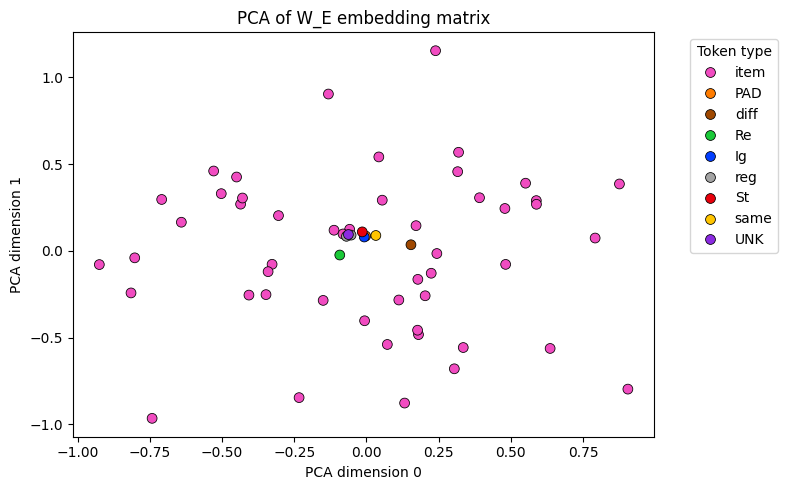

In [75]:
plot_embeddings(model, dataset, n_components=2, which="W_E", method="pca", dims=(0, 1))

torch.Size([128, 128])
fitting pca
Explained variance ratio: [0.7052086  0.16752616]
Length of values (59) does not match length of index (128) skipping labels
plotting


/tmp/ipykernel_3693024/734113776.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Token type")


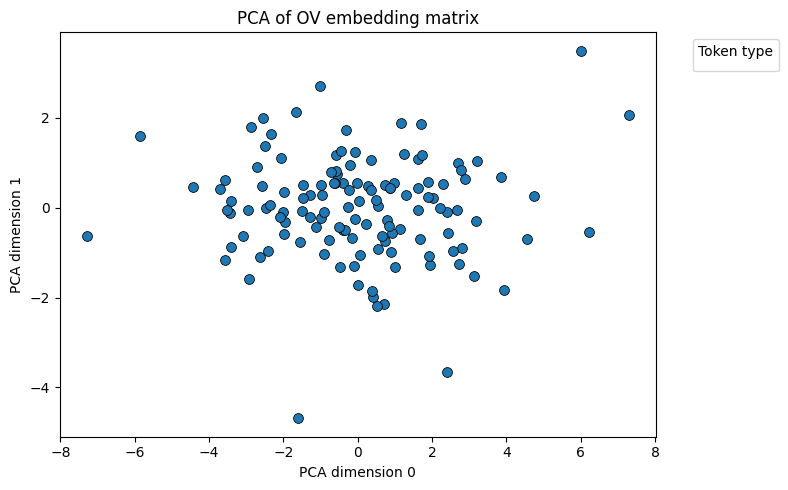

In [84]:
plot_embeddings(
    model,
    dataset,
    n_components=2,
    which="OV",
    method="pca",
    dims=(0, 1),
    layer_head=(1, 0),
)
